In [ ]:
#!pip install -q tfp-nightly

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from scipy.stats import norm
from catboost import CatBoostClassifier
import tensorflow as tf
#import tensorflow_probability as tfp
#from tensorflow_probability import edward2 as ed
#tfd = tfp.distributions

sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

## Data

TODO: intro

In [170]:
train = pd.read_csv('../input/train.csv', 
                    usecols=np.arange(1, 7),
                    nrows=100000)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],
                                          format='%Y-%m-%d %H:%M:%S %Z')

In [171]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762


Have to extract time of day, time of week, time of year, and year, and then drop the original datetime column.

In [172]:
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute)
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear
train['year'] = train['pickup_datetime'].dt.year
train.drop('pickup_datetime', axis=1, inplace=True)

In [173]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,min_of_day,day_of_week,day_of_year,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1046,0,166,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1012,1,5,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,35,3,230,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,270,5,112,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,471,1,68,2010


Let's check the fare amount distributions:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


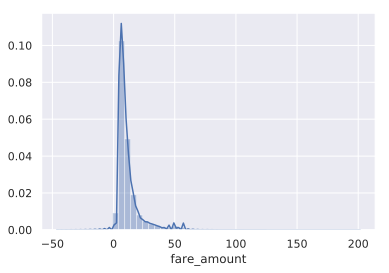

In [174]:
# Plot distribution of fares
sns.distplot(train['fare_amount'])
plt.show()

It looks like there might be some negative values (which doesn't make any sense, of course!). Let's zoom in on the area around 0.

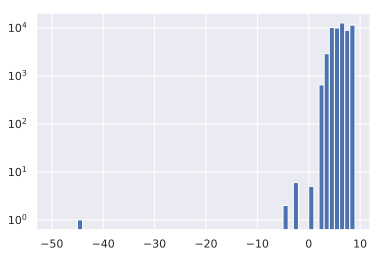

In [175]:
# Plot distribution of fares around 0
plt.hist(train['fare_amount'], 
         bins=np.arange(-50, 10), log=True)
plt.show()

Let's remove the datapoints with fares which are suspiciously low.

In [176]:
# Remove rows with too-low fares
train = train[train['fare_amount']>1]

Finally, let's check the locations of the pickups and dropoffs.

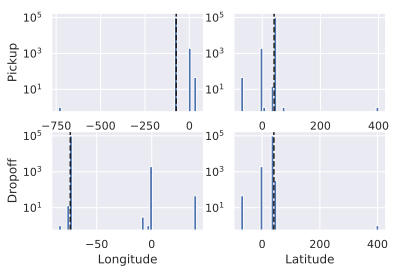

In [177]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

There are some outliers, especially at 0.  Let's remove rows with geographical locations outside a reasonable range (near the greater NYC metropolitan area).

In [178]:
# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove geographical outliers
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

And now we have only values which are near NYC:

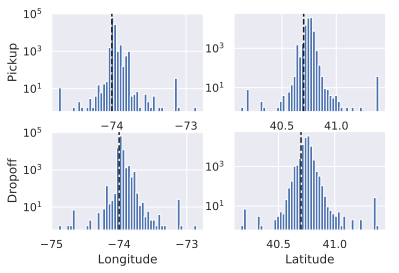

In [179]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

## Baseline Model

xgboost

In [180]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,min_of_day,day_of_week,day_of_year,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1046,0,166,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1012,1,5,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,35,3,230,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,270,5,112,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,471,1,68,2010


In [ ]:
'''
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from catboost import CatBoostClassifier

# Classification pipeline w/ catboost predictor
cb_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', CatBoostClassifier())
])

# Cross-validated MSE
scores = cross_val_score(cb_pipeline, cv=3, 
                         train.drop('fare_amount', axis=1), 
                         train['fare_amount'], 
                         scoring=make_scorer(mean_squared_error))
print('CatBoost Mean MSE:', scores.mean())
'''